# 1) Revisión de los ejemplos proporcionados

## Animal Image Classification Dataset
A dataset that contain common pets and wildlife: cats, dogs, and snakes.

Fuente: https://www.kaggle.com/datasets/borhanitrash/animal-image-classification-dataset

In [ ]:
import os
import numpy as np
import tensorflow_hub as hub
import tensorflow as tf
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances
from scipy.cluster.hierarchy import linkage, fcluster
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.manifold import TSNE

In [ ]:
# Ejecute esta celda si necesita extraer sus imagenes de un archivo zip

import zipfile
import os

def unzip_file(zip_path, extract_to):
    if not os.path.exists(zip_path):
        print(f"The file {zip_path} does not exist.")
        return

    os.makedirs(extract_to, exist_ok=True)

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
        print(f"Extracted all files to: {extract_to}")

# Ejemplo de uso
zip_file_path = "/content/archive.zip"  # Reemplace con la ruta de su archivo zip
output_directory = "/content/"  # Reemplace con la ruta donde desea dejar los archivos

unzip_file(zip_file_path, output_directory)

Extracted all files to: /content/


In [ ]:
# Función para cargar y preprocesar imágenes de subdirectorios de manera recursiva
def load_images(image_dir, image_size=(224, 224)):
    images = []
    image_names = []
    # The variable image_path was not defined before use.
    # It's likely intended to be used within the loop, so it's moved there.
    # Explorar todos los archivos en el directorio y subdirectorios
    for root, _, files in os.walk(image_dir):
        for file_name in files:
            if file_name.endswith(('jpg', 'jpeg', 'png')):
                # Ruta completa de la imagen
                image_path = os.path.join(root, file_name)

                # Cargar y procesar la imagen
                try:
                  image = Image.open(image_path).resize(image_size)
                  image = np.array(image) / 255.0  # Normalización
                  images.append(image)
                except Exception as e:
                  print(f"Error al cargar {image_path}: {e}")


                # Guardar el nombre con el subdirectorio relativo
                relative_path = os.path.relpath(image_path, image_dir)
                image_names.append(relative_path)

    return np.array(images), image_names

# Función para extraer embeddings usando un modelo preentrenado
def extract_embeddings_in_batches(images, model_url, batch_size=32):
    embedder = hub.KerasLayer(model_url)
    embeddings = []
    for i in range(0, len(images), batch_size):
        batch = images[i:i + batch_size]
        batch_tensor = tf.convert_to_tensor(batch)
        embeddings.append(embedder(batch_tensor).numpy())
    return np.vstack(embeddings)



In [ ]:
# Directorio con las imágenes
# reemplace con la ruta para sus imagenes
image_dir = "/content/Animals"

# Cargar imágenes
images, image_names = load_images(image_dir)

# Usar un modelo preentrenado para extraer características
model_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
#model_url = "https://tfhub.dev/google/imagenet/mobilenet_v1_100_224/feature_vector/4"

images_tensor = tf.convert_to_tensor(images)
embeddings = extract_embeddings_in_batches(images_tensor, model_url)


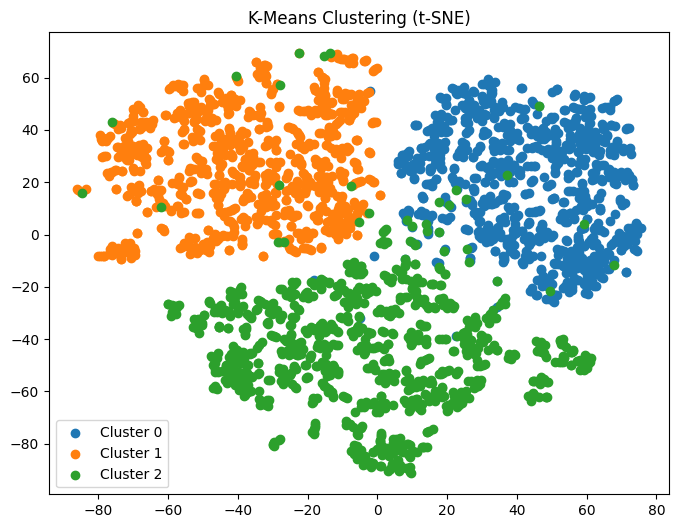

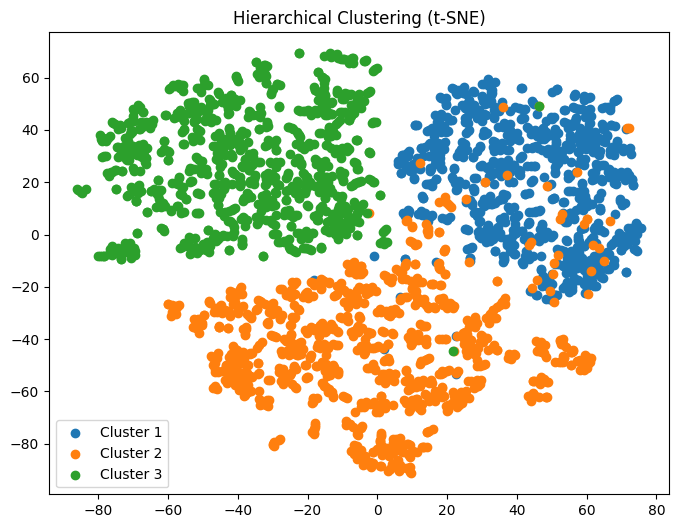

In [ ]:
# Clustering con K-Means
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(embeddings)

# Clustering jerárquico
linkage_matrix = linkage(embeddings, method='ward')  # Distancia euclidiana por defecto
hierarchical_labels = fcluster(linkage_matrix, t=num_clusters, criterion='maxclust')

# Reducción de dimensionalidad con t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
embeddings_2d = tsne.fit_transform(embeddings)

# Visualización de clusters con t-SNE
def visualize_clustering(embeddings_2d, labels, title):
    plt.figure(figsize=(8, 6))
    unique_labels = np.unique(labels)
    for label in unique_labels:
        cluster_points = embeddings_2d[labels == label]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {label}")
    plt.title(title)
    plt.legend()
    plt.show()

visualize_clustering(embeddings_2d, kmeans_labels, "K-Means Clustering (t-SNE)")
visualize_clustering(embeddings_2d, hierarchical_labels, "Hierarchical Clustering (t-SNE)")


K-Means (euclidean distance):
Average distance (same cluster): 23.5963
Average distance (different clusters): 26.2899


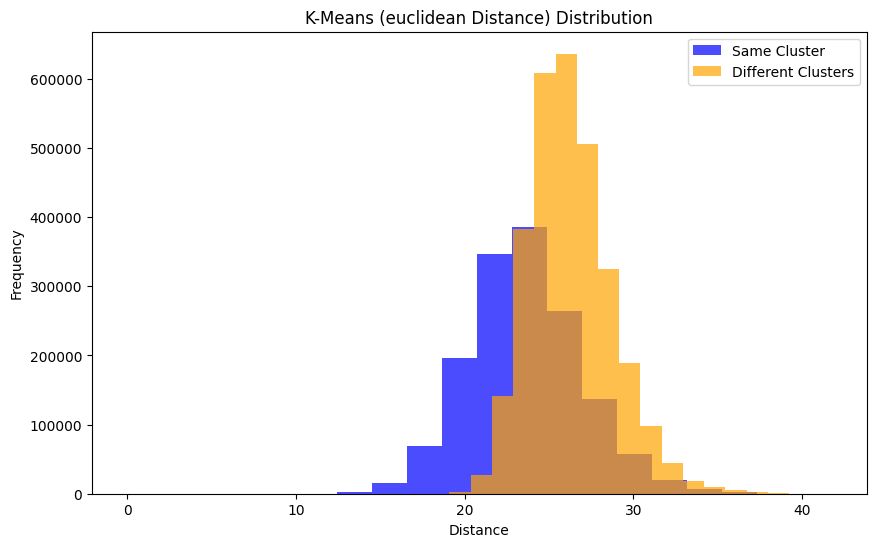


Hierarchical (euclidean distance):
Average distance (same cluster): 23.6496
Average distance (different clusters): 26.2660


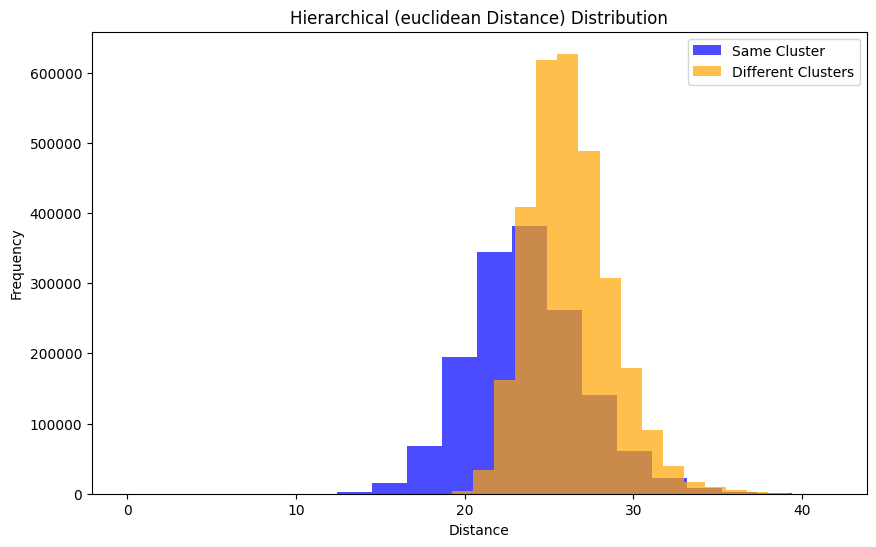

In [ ]:
# Función para calcular distancias entre imágenes
def calculate_distances(embeddings, labels, metric='euclidean'):
    distances_same_cluster = []
    distances_different_cluster = []
    n = len(labels)

    for i in range(n):
        for j in range(i + 1, n):
            dist = euclidean_distances([embeddings[i]], [embeddings[j]])[0][0] if metric == 'euclidean' else cosine_distances([embeddings[i]], [embeddings[j]])[0][0]
            if labels[i] == labels[j]:
                distances_same_cluster.append(dist)
            else:
                distances_different_cluster.append(dist)

    return distances_same_cluster, distances_different_cluster

# Mostrar distancias para cada técnica
def analyze_distances(embeddings, labels, method_name, metric='euclidean'):
    same_cluster, different_cluster = calculate_distances(embeddings, labels, metric=metric)
    print(f"\n{method_name} ({metric} distance):")
    print(f"Average distance (same cluster): {np.mean(same_cluster):.4f}")
    print(f"Average distance (different clusters): {np.mean(different_cluster):.4f}")

    # Histogramas de las distancias
    plt.figure(figsize=(10, 6))
    plt.hist(same_cluster, bins=20, alpha=0.7, label="Same Cluster", color='blue')
    plt.hist(different_cluster, bins=20, alpha=0.7, label="Different Clusters", color='orange')
    plt.title(f"{method_name} ({metric} Distance) Distribution")
    plt.xlabel("Distance")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

# Analizar distancias para cada técnica
analyze_distances(embeddings, kmeans_labels, "K-Means", metric="euclidean")
analyze_distances(embeddings, hierarchical_labels, "Hierarchical", metric="euclidean")


K-Means Cluster Images:


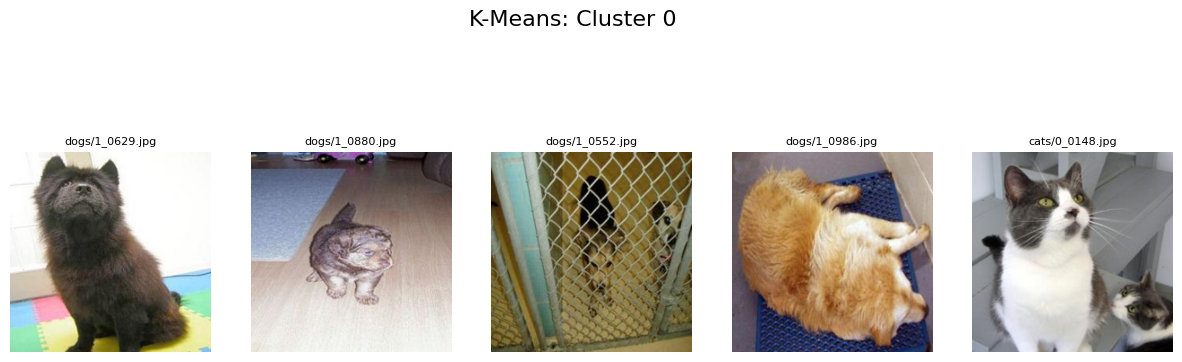

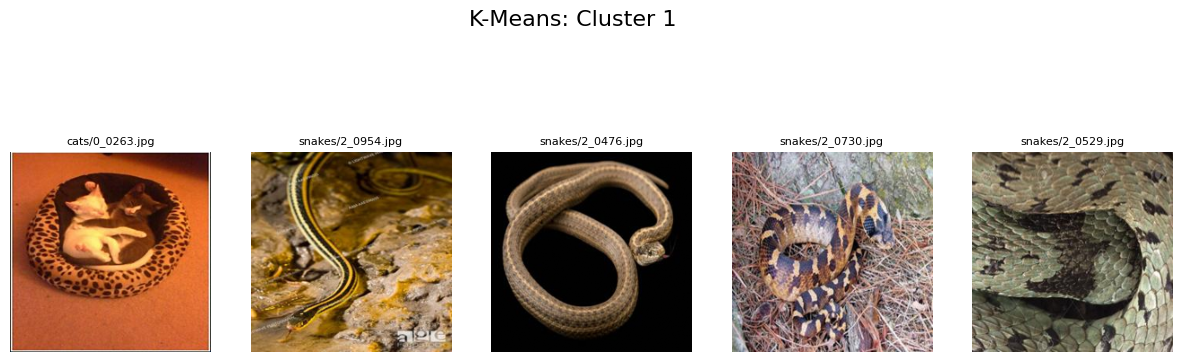

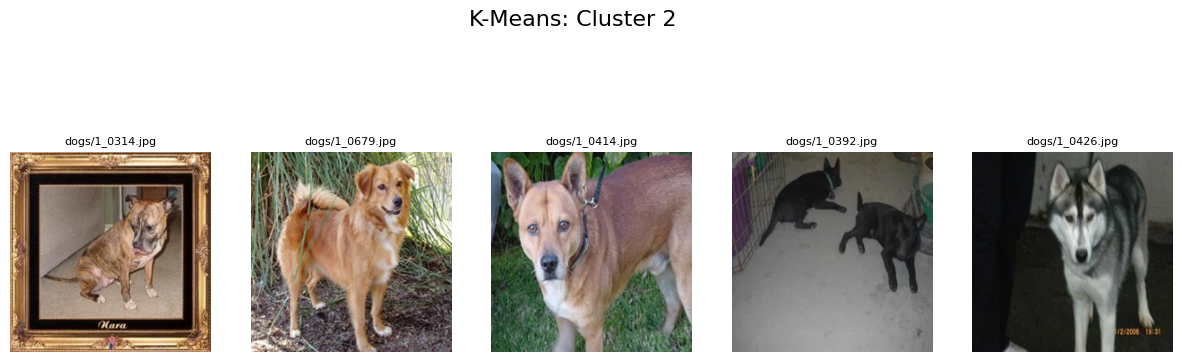


Hierarchical Cluster Images:


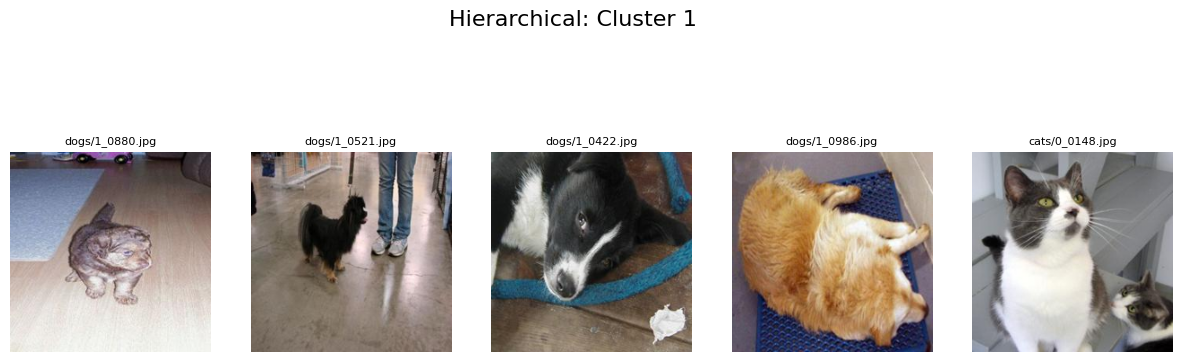

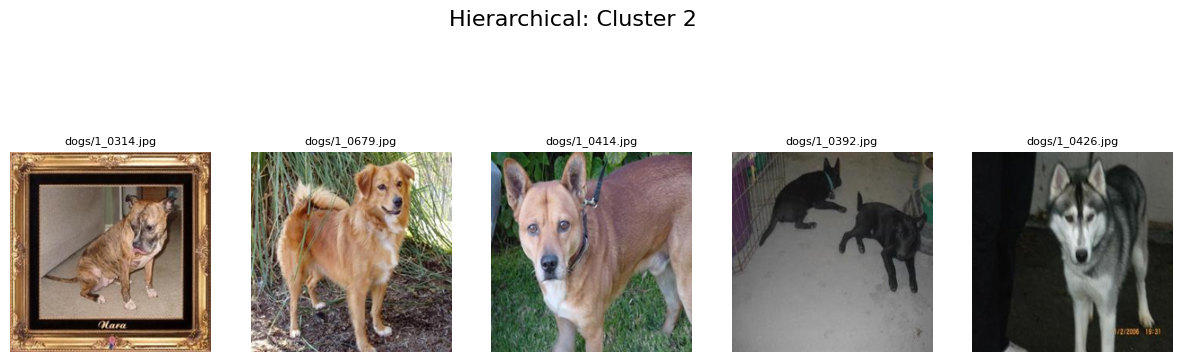

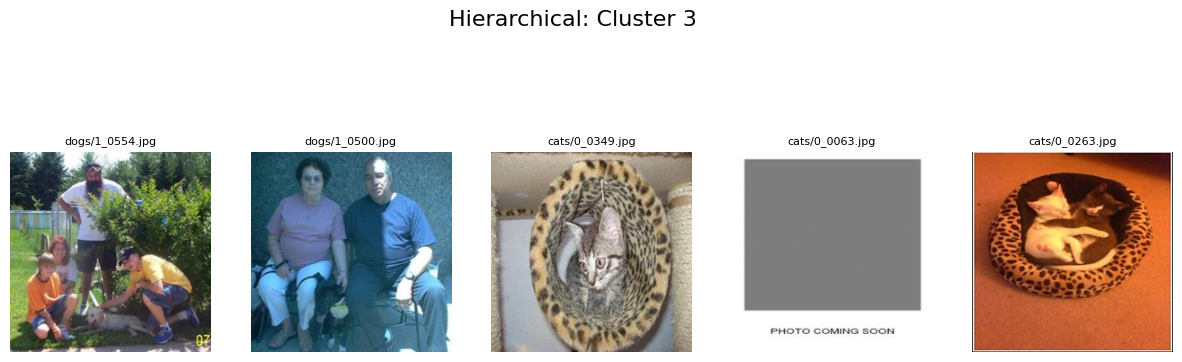

In [ ]:
# Visualización de imágenes de cada cluster
def show_cluster_images(images, image_names, labels, cluster_label, title, max_images=5):
    cluster_indices = np.where(labels == cluster_label)[0]
    cluster_images = images[cluster_indices][:max_images]
    cluster_names = np.array(image_names)[cluster_indices][:max_images]

    fig, axes = plt.subplots(1, len(cluster_images), figsize=(15, 5))
    fig.suptitle(f"{title}: Cluster {cluster_label}", fontsize=16)
    for i, (img, name) in enumerate(zip(cluster_images, cluster_names)):
        axes[i].imshow(img)
        axes[i].set_title(name, fontsize=8)
        axes[i].axis('off')
    plt.show()

# Mostrar imágenes de clusters para cada técnica
def show_all_clusters(images, image_names, labels, method_name, max_images=5):
    unique_labels = np.unique(labels)
    for cluster_label in unique_labels:
        if cluster_label == -1:  # DBSCAN noise
            continue
        show_cluster_images(images, image_names, labels, cluster_label, method_name, max_images)

print("\nK-Means Cluster Images:")
show_all_clusters(images, image_names, kmeans_labels, "K-Means")

print("\nHierarchical Cluster Images:")
show_all_clusters(images, image_names, hierarchical_labels, "Hierarchical")


# 2) Recomendación:
Dada una imagen de un artículo de vestir, encuentre dentro del conjunto de imagenes de artículos de moda (ver recursos requeridos) los 3 artículos más parecidos a la imagen dada.

In [21]:
import os
import numpy as np
import tensorflow_hub as hub
import tensorflow as tf
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances
from scipy.cluster.hierarchy import linkage, fcluster
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.manifold import TSNE
import matplotlib.image as mpimg


In [4]:
def load_images(image_dir, image_size=(224, 224),batch_size=800):
    images = []
    image_names = []

    # Explorar todos los archivos en el directorio y subdirectorios
    for root, _, files in os.walk(image_dir):
        for file_name in files:
            if file_name.endswith(('jpg', 'jpeg', 'png')):

                image_path = os.path.join(root, file_name)

                # Cargar y procesar la imagen
                image = Image.open(image_path).convert('RGB')
                image = image.resize(image_size)
                image = np.array(image) / 255.0  # Normalización
                images.append(image)


                relative_path = os.path.relpath(image_path, image_dir)
                image_names.append(relative_path)

                if len(images) == batch_size:
                        yield np.array(images), image_names
                        images, image_names = [], []

    if images:
        yield np.array(images), image_names

#  embeddings usando un modelo preentrenado
def extract_embeddings(images, model_url,batch_size=800):
    #Numero de lotes
    num_batches = len(images) // batch_size + (1 if len(images) % batch_size > 0 else 0)
    embedder = hub.KerasLayer(model_url)
    embeddings_list = []
    for i in range(num_batches):
        batch = images[i * batch_size : (i + 1) * batch_size]
        images_tensor = tf.convert_to_tensor(batch)
        embeddings_batch = embedder(images_tensor)
        embeddings_list.append(embeddings_batch.numpy())

    return np.vstack(embeddings_list)

In [2]:
# Ejecute esta celda si necesita extraer sus imagenes de un archivo zip

import zipfile
import os

def unzip_file(zip_path, extract_to):
    if not os.path.exists(zip_path):
        print(f"The file {zip_path} does not exist.")
        return

    os.makedirs(extract_to, exist_ok=True)

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
        print(f"Extracted all files to: {extract_to}")

# Ejemplo de uso
zip_file_path = "/content/archive.zip"  # Reemplace con la ruta de su archivo zip
output_directory = "/content/"  # Reemplace con la ruta donde desea dejar los archivos

unzip_file(zip_file_path, output_directory)

Extracted all files to: /content/


In [7]:
# Directorio con las imágenes
# reemplace con la ruta para sus imagenes
import gc
path = '/content/images'
image_dir = path
model_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

# Cargar imágenes
# Procesar todas las imágenes en lotes
all_embeddings = []
all_image_names = []


for images_batch, image_names_batch in load_images(image_dir):
    print(f"Procesando lote con {len(images_batch)} imágenes...")

    # Verificar si images_batch está vacío
    if len(images_batch) == 0:
        print("El lote de imágenes está vacío. Saltando...")
        continue  # Saltar al siguiente lote

    # Generar embeddings para el lote actual
    embeddings_batch = extract_embeddings(images_batch, model_url)

    # Agregar embeddings y nombres del lote a las listas
    all_embeddings.append(embeddings_batch)
    all_image_names.extend(image_names_batch)

    # Liberar memoria del lote procesado
    del images_batch, image_names_batch, embeddings_batch
    gc.collect()

# Verificar si all_embeddings está vacío antes de llamar a vstack
if all_embeddings:
    all_embeddings = np.vstack(all_embeddings)
else:
    print("No se encontraron embeddings. all_embeddings está vacío.")
    # Manejar el caso en que all_embeddings está vacío (por ejemplo, asignar un array vacío)
    all_embeddings = np.array([])

# Resultado final
print(f"Total de embeddings generados: {all_embeddings.shape[0]}")
print(f"Dimensiones de cada embedding: {all_embeddings.shape[1]}")

Procesando lote con 800 imágenes...
Procesando lote con 800 imágenes...
Procesando lote con 800 imágenes...
Procesando lote con 800 imágenes...
Procesando lote con 800 imágenes...
Procesando lote con 800 imágenes...
Procesando lote con 800 imágenes...
Procesando lote con 800 imágenes...
Procesando lote con 800 imágenes...
Procesando lote con 800 imágenes...
Procesando lote con 800 imágenes...
Procesando lote con 800 imágenes...
Procesando lote con 800 imágenes...
Procesando lote con 800 imágenes...
Procesando lote con 800 imágenes...
Procesando lote con 800 imágenes...
Procesando lote con 800 imágenes...
Procesando lote con 800 imágenes...
Procesando lote con 800 imágenes...
Procesando lote con 800 imágenes...
Procesando lote con 800 imágenes...
Procesando lote con 800 imágenes...
Procesando lote con 800 imágenes...
Procesando lote con 800 imágenes...
Procesando lote con 800 imágenes...
Procesando lote con 800 imágenes...
Procesando lote con 800 imágenes...
Procesando lote con 800 imág

In [19]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def find_most_similar_items(query_image_path, all_embeddings, all_image_names, top_n=3):
    """
    Encuentra los elementos más similares a una imagen de consulta dada.

    Args:
        query_image_path: Ruta de la imagen de consulta.
        all_embeddings: Matriz de embeddings de todas las imágenes del conjunto de datos.
        all_image_names: Lista de nombres de las imágenes correspondientes a los embeddings.
        top_n: Número de elementos más similares a retornar.

    Returns:
        Una lista con los nombres de archivos de las imágenes más similares.
    """

    try:
        # Cargar y procesar la imagen de consulta
        query_image = Image.open(query_image_path).convert('RGB')
        query_image = query_image.resize((224, 224))
        query_image = np.array(query_image) / 255.0
        query_image = np.expand_dims(query_image, axis=0)  # Agrega una dimensión para el lote

        # Extraer embeddings de la imagen de consulta
        embedder = hub.KerasLayer(model_url)
        query_embedding = embedder(tf.convert_to_tensor(query_image))
        query_embedding = query_embedding.numpy()


        # Calcular la similitud del coseno entre la imagen de consulta y todas las imágenes del conjunto de datos
        similarities = cosine_similarity(query_embedding, all_embeddings)

        # Obtener los índices de las imágenes más similares
        most_similar_indices = np.argsort(similarities[0])[::-1][:top_n]

        # Obtener los nombres de los archivos de las imágenes más similares
        most_similar_items = [all_image_names[i] for i in most_similar_indices]

        return most_similar_items

    except Exception as e:
        print(f"Error al procesar la imagen: {e}")
        return []

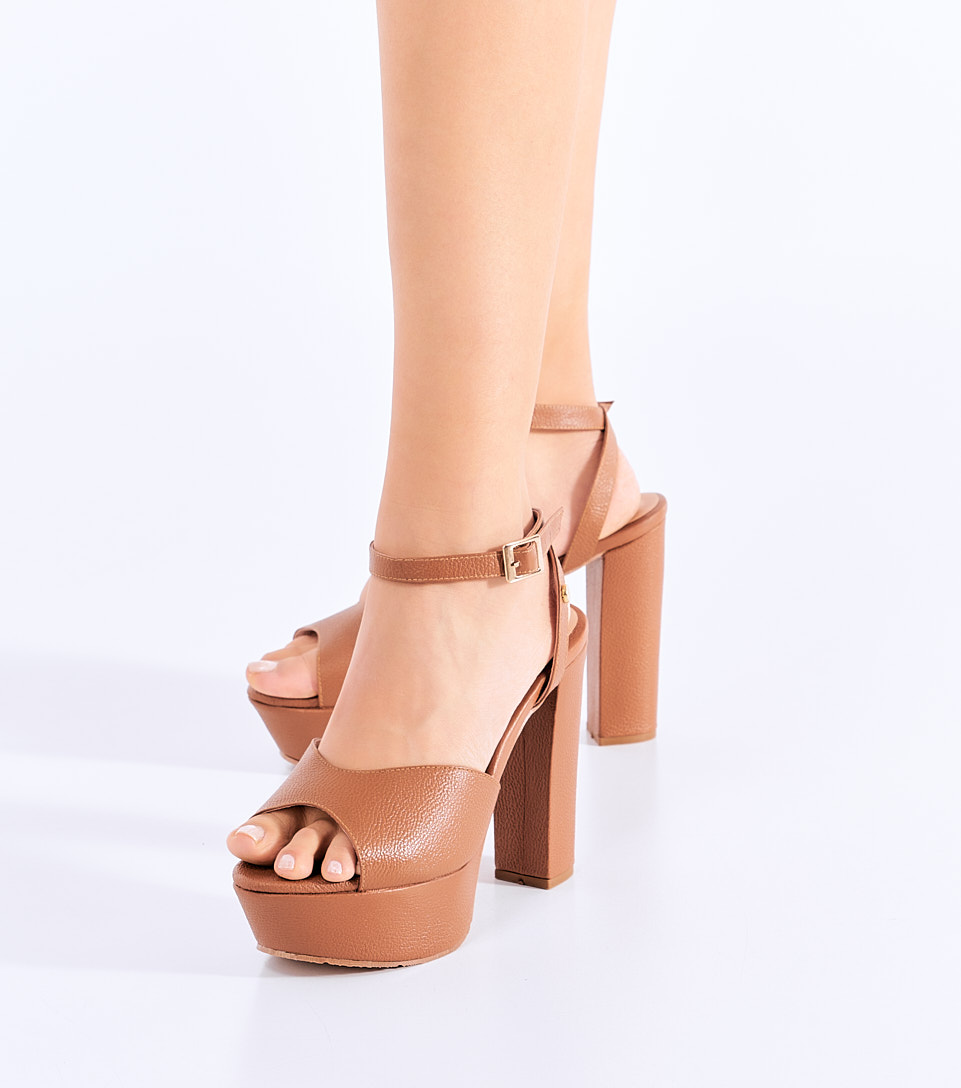

In [20]:
query_image_path = "/content/zapatilla1.jpg"  # Reemplace con la ruta de su imagen de consulta

most_similar = find_most_similar_items(query_image_path, all_embeddings, all_image_names)
print(f"Las {len(most_similar)} imágenes más similares son: {most_similar}")

Las 3 imágenes más similares son: ['41736.jpg', '39607.jpg', '39599.jpg']


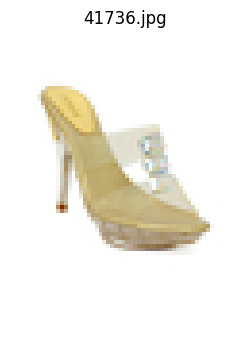

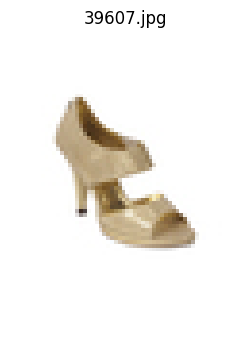

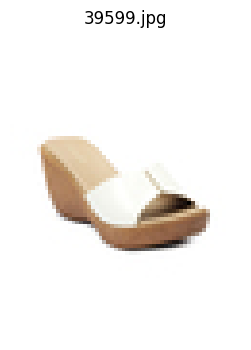

In [22]:
def show_images(image_paths, image_dir):
  """Displays images from a list of paths."""

  for image_path in image_paths:
      full_path = os.path.join(image_dir, image_path)
      if os.path.exists(full_path):
          try:
              img = mpimg.imread(full_path)
              plt.figure(figsize=(4, 4))  # Adjust figure size as needed
              plt.imshow(img)
              plt.title(image_path)
              plt.axis('off')  # Hide axes
              plt.show()
          except Exception as e:
              print(f"Error displaying {image_path}: {e}")
      else:
          print(f"Image file not found: {full_path}")

image_directory = "/content/images"
show_images(most_similar, image_directory)

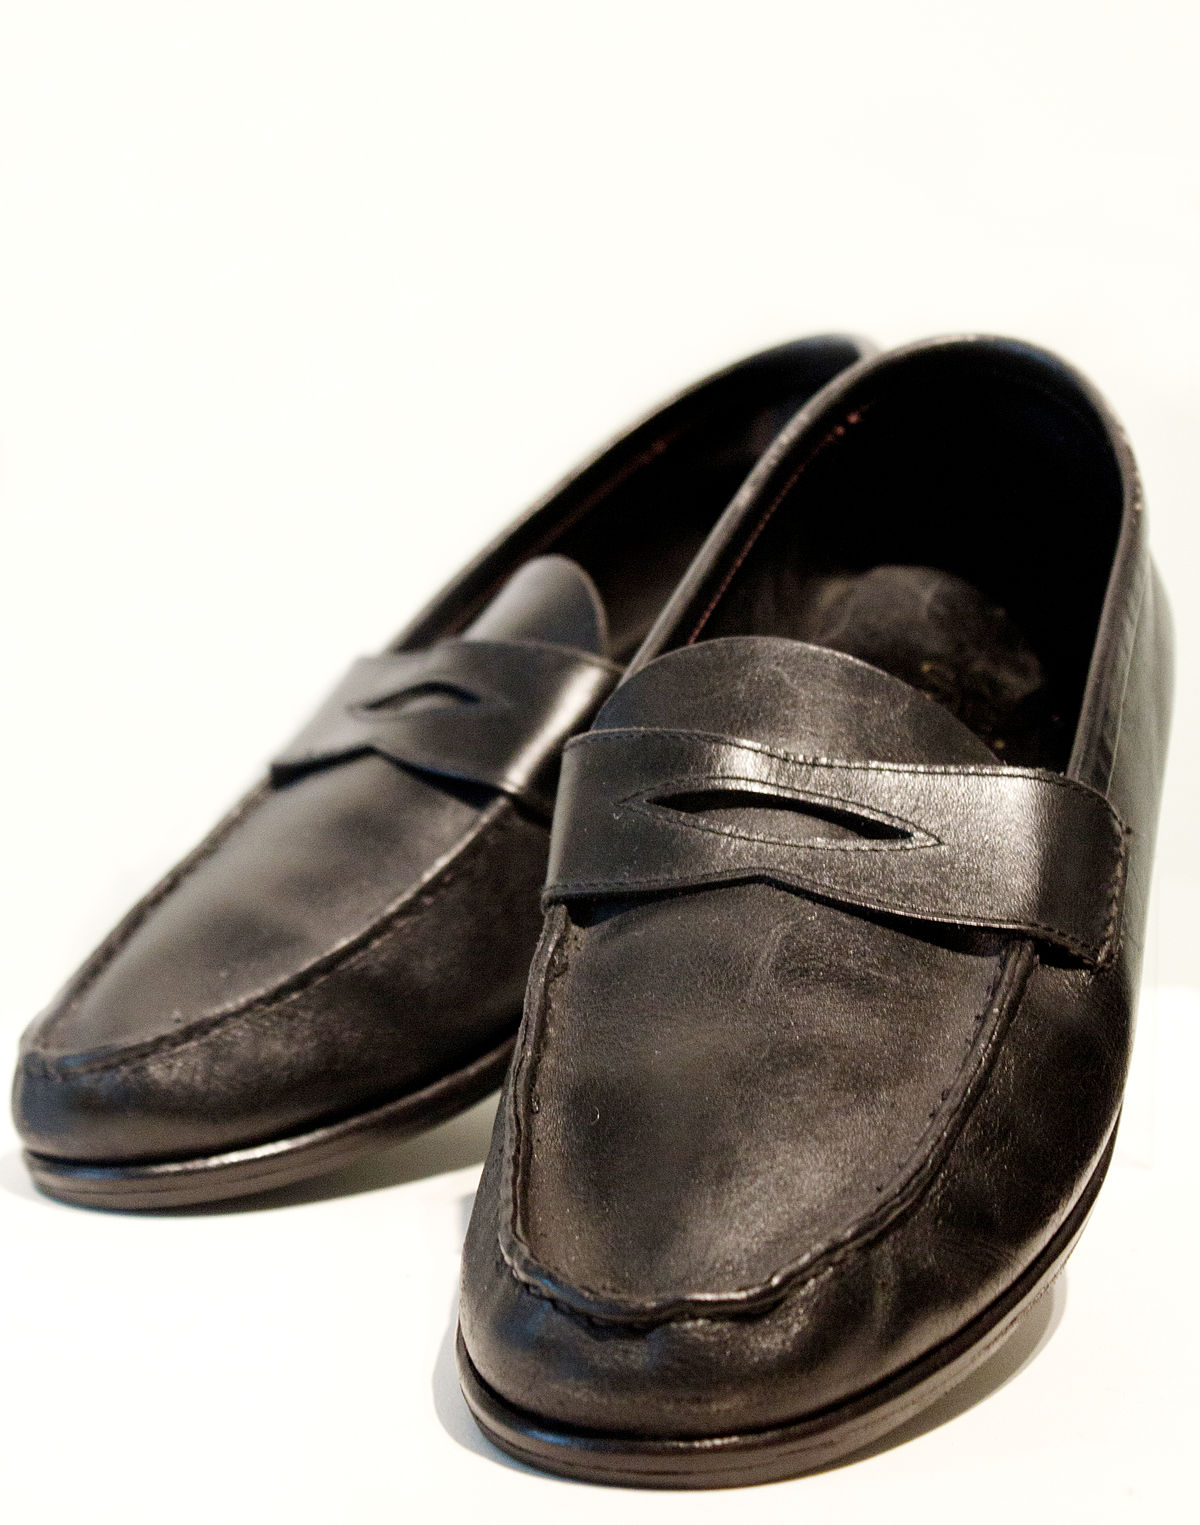

In [23]:
query_image_path = "/content/zapatos.jpg"  # Reemplace con la ruta de su imagen de consulta

most_similar = find_most_similar_items(query_image_path, all_embeddings, all_image_names)
print(f"Las {len(most_similar)} imágenes más similares son: {most_similar}")

Las 3 imágenes más similares son: ['12859.jpg', '37957.jpg', '37973.jpg']


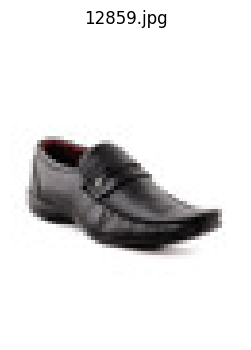

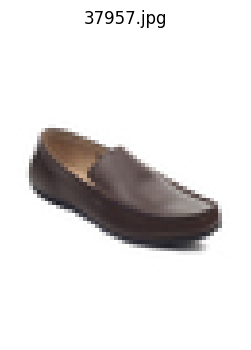

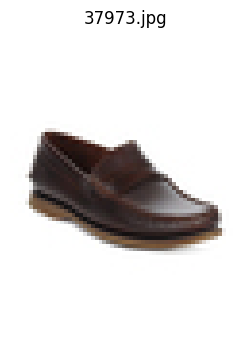

In [24]:
def show_images(image_paths, image_dir):
  """Displays images from a list of paths."""

  for image_path in image_paths:
      full_path = os.path.join(image_dir, image_path)
      if os.path.exists(full_path):
          try:
              img = mpimg.imread(full_path)
              plt.figure(figsize=(4, 4))  # Adjust figure size as needed
              plt.imshow(img)
              plt.title(image_path)
              plt.axis('off')  # Hide axes
              plt.show()
          except Exception as e:
              print(f"Error displaying {image_path}: {e}")
      else:
          print(f"Image file not found: {full_path}")

image_directory = "/content/images"
show_images(most_similar, image_directory)

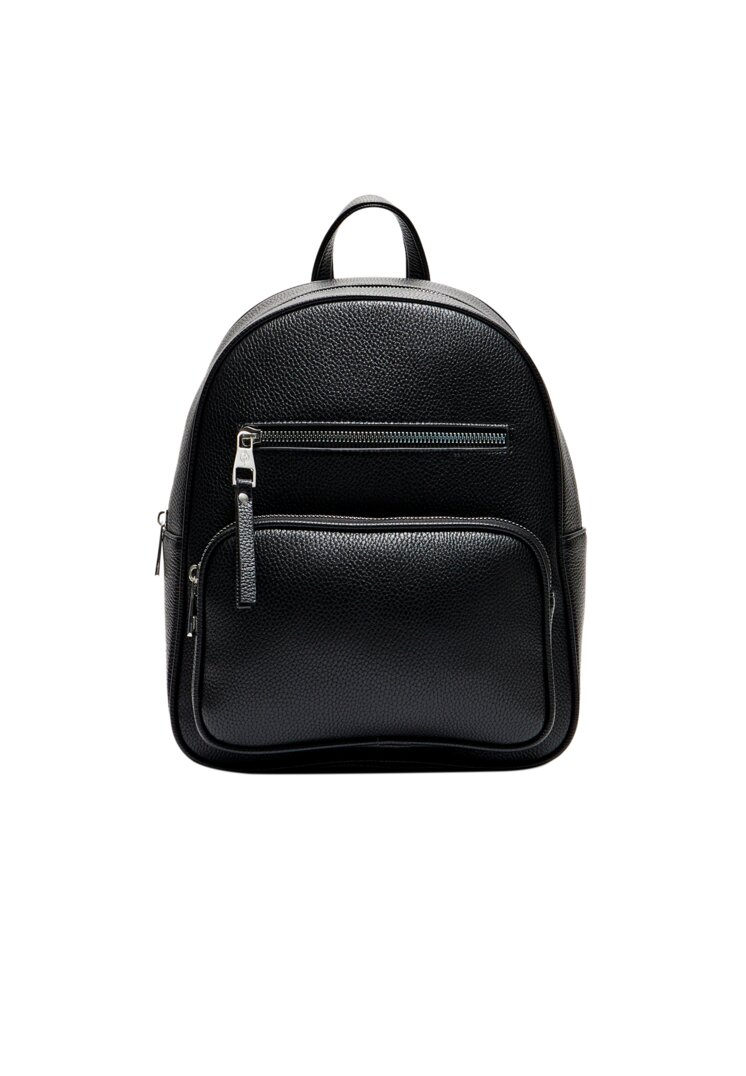

In [28]:
query_image_path = "/content/mochila.jpg"  # Reemplace con la ruta de su imagen de consulta

most_similar = find_most_similar_items(query_image_path, all_embeddings, all_image_names)
print(f"Las {len(most_similar)} imágenes más similares son: {most_similar}")

Las 3 imágenes más similares son: ['19318.jpg', '21264.jpg', '42933.jpg']


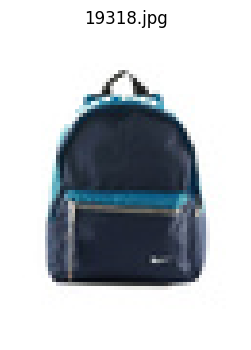

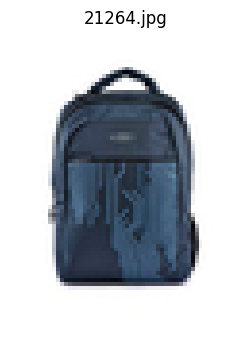

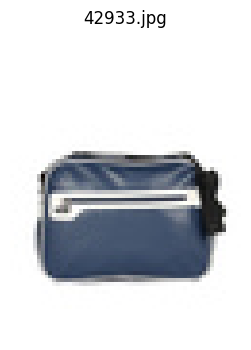

In [29]:
def show_images(image_paths, image_dir):
  """Displays images from a list of paths."""

  for image_path in image_paths:
      full_path = os.path.join(image_dir, image_path)
      if os.path.exists(full_path):
          try:
              img = mpimg.imread(full_path)
              plt.figure(figsize=(4, 4))  # Adjust figure size as needed
              plt.imshow(img)
              plt.title(image_path)
              plt.axis('off')  # Hide axes
              plt.show()
          except Exception as e:
              print(f"Error displaying {image_path}: {e}")
      else:
          print(f"Image file not found: {full_path}")

image_directory = "/content/images"
show_images(most_similar, image_directory)